<a href="https://colab.research.google.com/github/Andrea-Apicella/Fall_Detection/blob/main/LSTM_on_poses_extracted_with_PoseNet_%2B_MobileNetV2_Timeseries_of_20_frames_(URFall_%2B_Multicam)_first_half.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM for Fall Detection (+ MobileNetV2)
On poses extracted with PoseNet and MobileNetV2

##Import Libraries

In [1]:
# LIBRARIES AND UTILITIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

##Utility Functions
For loading features and generating one label for each time series

In [2]:
#For loading features and producing shape (numSeries, 20, 34)
def load_X(X_path):
    '''Loads features (posenet joints) and parses them in series of "serie_length" elements'''
    file = open(X_path, 'r')
    X_= np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / serie_length)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

In [3]:
# DEFINING A FUNCTION TO HAVE ONE LABEL FOR EACH SERIE OF serie_length POSES
def condense_labels(labels, serie_length):
    """Condenses n labels in 1 choosing the most frequent among the n ones, where n is serie_length """
    if (len(labels) % serie_length) == 0:
        num_groups = len(labels) / serie_length
        groups = np.split(labels , num_groups)
        output=[]
        for group in groups:
            listed = group.tolist()
            for label in listed:
                a = listed.count(1)
                b = listed.count(0)
            newvalue = {a : '1', b : '0'}
            newlabel = newvalue.get(max(newvalue))
            output.append(int(newlabel))
        return np.asarray(output)
    else:
      print('Errore: labels not divisible for serie_length')
      return

###Utility variables

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path =  '/content/drive/MyDrive/Colab Notebooks/Tirocinio/Training LSTM su pose estratte'

In [6]:
# LENGTH OF EACH SERIE OF POSES
serie_length = 20

## Importing and processing Labels

###Import URFall labels
URFall labels were provided by the authors of the dataset in a CSV file.

In [7]:
# Loading URFall provided CSV file
urfd_labels = pd.read_csv( data_path+'/data_rnn_cnn/urfall-cam0-falls.csv',header=None,sep=',' )
urfd_labels.head()


,0,1,2,3,4,5,6,7,8,9,10
0,fall-01,1,-1,3.1667,2.9098,0.55367,126.0258,1.0324,1899.5366,1055.9988,0.047310
1,fall-01,2,-1,3.3067,2.9699,0.47876,125.5657,1.1251,2070.1193,1065.9506,0.048175
2,fall-01,3,-1,3.1408,3.0506,0.54374,123.1570,1.0161,1869.6442,1055.4955,0.050180
3,fall-01,4,-1,3.4306,3.1435,0.48859,124.5614,1.1251,2070.1193,1076.1464,0.047877
4,fall-01,5,-1,3.6324,3.3012,0.49744,123.6089,1.1251,2070.1193,1075.5053,0.052543


In [8]:
#extracting frames' labels
urfd_labels = urfd_labels.iloc[:,2]
print('Number of labels: ', len(urfd_labels))

Number of labels:  2995


In [9]:
#checking number of elements of each URFall class
print('Number of labels for each class:\n', urfd_labels.value_counts())

Number of labels for each class:
 -1    1192
 1     903
 0     900
Name: 2, dtype: int64


###Make URFall labels binary
By condensing lying down and fall classes

In [10]:
urfd_labels=urfd_labels.replace(0,3) 
urfd_labels=urfd_labels.replace(-1,0)
urfd_labels=urfd_labels.replace(3,1)

print('Number of labels for each class:\n', urfd_labels.value_counts())

Number of labels for each class:
 1    1803
0    1192
Name: 2, dtype: int64


In [11]:
#using only half of the labels
urfd_labels=urfd_labels.iloc[:1520]
urfd_labels.columns=['labels']
print('Number of labels for each class:\n', urfd_labels.value_counts())

Number of labels for each class:
 1    831
0    689
Name: 2, dtype: int64


##Import Multicam labels
Labels generated with a script following the structure provided in Multicam's documentation.

These are Multicam's first half labels.



In [12]:
multicam_labels = pd.read_csv(data_path+'/data_rnn_cnn/multicam_labels_1_11_divisible_by_20.csv', header = None)
multicam_labels = multicam_labels.iloc[:, 0]
print('Multicam labels count:')
multicam_labels.value_counts()

Multicam labels count:


0    18184
1    12056
Name: 0, dtype: int64

##Join URFall and Multicam labels
to have our combined dataset's first half labels

In [13]:
#joining URFall and Multicam labels
urfd_multicam_labels = multicam_labels.append(urfd_labels, ignore_index = True)
print('Total labels number: ' ,len(urfd_multicam_labels))
print('Labels for each class:')
print(urfd_multicam_labels.value_counts())


Total labels number:  31760
Labels for each class:
0    18873
1    12887
dtype: int64


##Condense Labels
Using condense_labels function to go from one label per frame to one label per series 

In [14]:
#using condense_labels function to generate adequate labels for the time series
urfd_multicam_labels = condense_labels(urfd_multicam_labels, serie_length)
print('Shape of series of poses\' labels: ', urfd_multicam_labels.shape)

Shape of series of poses' labels:  (1588,)


##Load poses 

In [15]:
urfd_multicam_features = load_X(data_path+'/data_rnn_cnn/Multicam_URFD_first_half_MOBILENETV2.csv')
print('Series of poses shape: ' , urfd_multicam_features.shape)

Series of poses shape:  (1588, 20, 34)


##Generate Training and Validation splits

In [16]:
input_shape = (None,) + (urfd_multicam_features.shape[1:])
print(input_shape)

(None, 20, 34)


In [17]:
#Splitting dataset into 80% training and 20% validation with train_test_split method from sklearn library
X_train, X_test, y_train, y_test = train_test_split(urfd_multicam_features, urfd_multicam_labels, test_size = 0.2, random_state = 4)

In [18]:
#Checking shapes
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (1270, 20, 34)
X_test shape:  (318, 20, 34)
y_train shape:  (1270,)
y_test shape:  (318,)


#LSTM

##Creating the model

LSTM with 34 units per layer. Adding more layers or units did not improve the results.

In [19]:
#MODEL
model = Sequential()

model.add(LSTM(units = 34, batch_input_shape = input_shape, return_sequences = True)) #By not specifying activation, Tensorflow under the hood uses CuDNN layers. These are much faster than standard LSTM and use tanh activation as default.
model.add(Dropout(0.2))

model.add(LSTM(units = 34, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.00001), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 34)            9384      
_________________________________________________________________
dropout (Dropout)            (None, 20, 34)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 34)                9384      
_________________________________________________________________
dropout_1 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 35        
Total params: 18,803
Trainable params: 18,803
Non-trainable params: 0
_________________________________________________________________


##Training the model

In [20]:
#Stops training when the loss does not get better for 100 consecutive epochs 
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 70)

In [21]:

model.fit(X_train,y_train, epochs = 1000, validation_data = (X_test,y_test), callbacks = [early_stop], verbose=1)

Epoch 1/1000
40/40 [==============================] - 10s 27ms/step - loss: 0.7013 - accuracy: 0.5221 - val_loss: 0.7062 - val_accuracy: 0.5000
Epoch 2/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6966 - accuracy: 0.5463 - val_loss: 0.7047 - val_accuracy: 0.5031
Epoch 3/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6998 - accuracy: 0.5178 - val_loss: 0.7029 - val_accuracy: 0.5094
Epoch 4/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6970 - accuracy: 0.5435 - val_loss: 0.7014 - val_accuracy: 0.5126
Epoch 5/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.6968 - accuracy: 0.5377 - val_loss: 0.6998 - val_accuracy: 0.5094
Epoch 6/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5608 - val_loss: 0.6984 - val_accuracy: 0.5126
Epoch 7/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.5344 - val_loss: 0.6969 - val_accuracy: 0.5126
Epo

##Visualize Results

[Text(0, 0.5, 'metrics'),
 Text(0.5, 0, 'epochs'),
 Text(0.5, 1.0, 'Training LSTM (w/ MobileNetV2) on URFD_Multicam_first_half')]

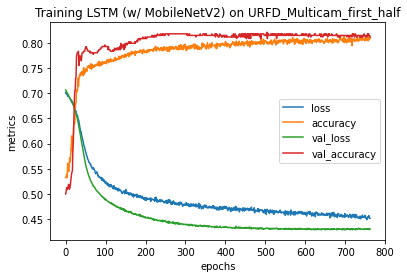

In [22]:
#RESULTS
losses = pd.DataFrame(model.history.history)
losses_plot = losses.plot()
losses_plot.set(xlabel = "epochs", ylabel = "metrics", title = 'Training LSTM (w/ MobileNetV2) on URFD_Multicam_first_half')


In [23]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions, target_names=['label 0: No Fall','label 1:    Fall'], digits = 3))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

label 0: No Fall      0.833     0.867     0.850       196
label 1:    Fall      0.772     0.721     0.746       122

        accuracy                          0.811       318
       macro avg      0.803     0.794     0.798       318
    weighted avg      0.810     0.811     0.810       318

